# 7. 프로젝트: Spectrogram classification 모델 구현   

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.

## 1. 데이터 처리와 분류

### 라벨 데이터 처리하기 

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


#### 데이터를 살펴보니 1초 길이의 오디오 음성데이터 50620개로 이루어져 있고, 16000개의 sample rate를 8000개로 re-sampling해서 사용하겠습니다. 

In [2]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


#### 학습을 위해서 현재 Text 형태의 파일을 index 형태로 바꿔주었습니다.

In [3]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

#### 살펴보니 다 int로 이루진 데이터가 잘 배열되어 있는 걸  확인할수 있습니다.

In [4]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


#### 위의 1차원 데이터는 다루어 봤으니 바로 2차원 데이터로 학습을 시키는 과제를 해볼까요? 일단 FFT 관련 라이브러리인 librosa를 설치하고 불러옵니다

In [5]:
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

In [6]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", spec.shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 130, 126)


#### 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환된것을 확인 할수가 있습니다. 이부분이 너무 어려웠습니다. 의외로 간단한 함수였는데 이걸 해결하지 못해 반나절을 그냥 보낸것 같아요. 아... 내시간... 그 시간에 밀린 코딩 숙제를 했어야 했는데... TT

### sklearn의 train_test_split함수를 이용하여 train, test 분리 

In [7]:
from sklearn.model_selection import train_test_split

sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec.shape)
print(train_label.shape)
print(test_spec.shape)
print(test_label.shape)

(45558, 130, 126)
(45558,)
(5062, 130, 126)
(5062,)


#### split함수를 이용하여 train, test 분리 했습니다. 45558개의 train set과 5062개의 test set으로 분리가 되었네요.

In [8]:
del speech_data

In [9]:
del spec

#### 메모리 용량이 딸리는지 계속 작동이 멈춰서 너무 힘들었습니다. 이것 저것 다 해봐도 이유를 알수가 없어서 재부팅을 했더니 겨우 여기까지는 넘어왔습니다. 그리고 불필요한 데이터를 지웠는데 자꾸 멈출까봐 조마조마 하네요.

## 2. 학습을 위한 하이퍼파라미터 설정

In [10]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj05/aiffel/speech_recognition/models/wav'

#### 겁나서 에포크를 많이 줄수가 없네요. 맘같아선 10을 주고 싶지만 밤을 새야 할것 같은 불길한 예감이 들어 5로줬습니다.

## 3. 데이터셋 구성

### tf.data.Dataset을 이용 
### from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용 

In [11]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


### map과 batch를 이용한 데이터 전처리 

In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

### 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용
### batchnorm, dropout, dense layer 등을 이용 

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용 

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### 모델 가중치를 저장하는 checkpoint callback 함수 추가 

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### 다양한 모델의 실험을 진행

In [18]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7767
Epoch 00001: val_loss improved from inf to 0.34142, saving model to /home/aiffel-dj05/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 704s 494ms/step - loss: 0.6715 - accuracy: 0.7767 - val_loss: 0.3414 - val_accuracy: 0.8843
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9250
Epoch 00002: val_loss improved from 0.34142 to 0.19750, saving model to /home/aiffel-dj05/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 717s 504ms/step - loss: 0.2345 - accuracy: 0.9250 - val_loss: 0.1975 - val_accuracy: 0.9347
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9490
Epoch 00003: val_loss improved from 0.19750 to 0.17115, saving model to /home/aiffel-dj05/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 728s 512ms/st

#### tensorflower gpu도 잘 설치 되어있고 작동 되는것도 확인이 되었는데 너무 시간이 오래 걸립니다 ㅜㅜ 한 에포크당 10분이 소요 되는 바람에 너무 오래 걸려 다음 진행이 어려웠습니다. 이거부터 해결해야 다음 진행도 될듯한데... 산넘어 산이네 ... 잠은 언제 잔다냐!!!!

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

### loss, accuracy를 그래프로 표현 

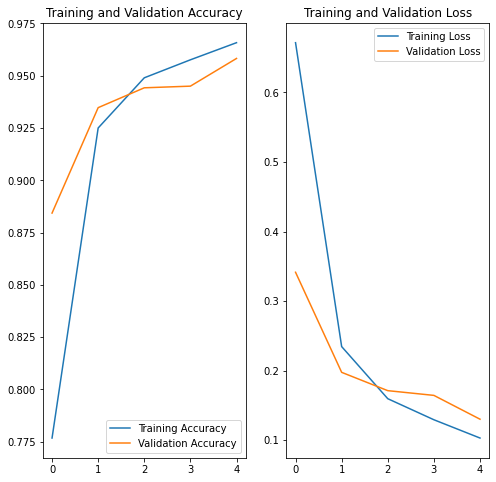

✅


In [19]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

#### 데이터 양이 충분해서 인지 accuracy는 높고, loss값은 낮은걸로 봐서 학습이 아주 잘된듯 보입니다. 뿌듯... 내가한건 아니지만 ...

## 6. Test dataset을 이용해서 모델의 성능을 평가

### 저장한 weight 불러오기

In [20]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


### 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [21]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 86s 540ms/step - loss: 0.1300 - accuracy: 0.9583
✅


In [22]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.130
accuracy value: 95.8317%
✅


#### 이렇게 수치로 환산하고 보니 정말 학습이 잘 되었군요!!

In [28]:
import IPython.display as ipd
import random

In [31]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)
a= librosa.istft(batch_xs.reshape(130,126))

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(a, rate=8000)

label :  silence


#### 

In [32]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: silence(Correct!)
✅


#### 와우~ 정말 완벽하게 맞췄네요.

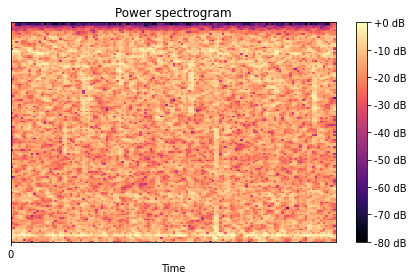

In [33]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

#### 스펙트로그램이 정말 예쁘게 잘 그려졌네요. 앗싸~~~~

## 총평

### 주말을 이 과제로 다 날렸지만, 그래도 하나씩 해결되는 것들을 보니 눈물이 납니다.  컴맹이던 내가 지금 이걸 하고 있다니...TT 아멘!! 데이터가 너무 커서 리부팅을 20번도 넘게 하는 바람에 뚜껑이 열려 한겨울도 한여름처럼 느껴졌어요. 그래도 해냈으니 다행입니다.   아직 모든것들이 다 이해되지는 않지만 팀들의 도움을 받아서 조금씩 성장하는 즐거움을 느끼고 있네요. 텍스트 데이터부터 이미지 데이터를 지나 이제 음성데이터까지 하나씩 알아가게 되서 힘들지만 보람됩니다. 이제 자러갑니다. zzzzzzz~